## Diffusive shock acceleration at moving shocks

DSA is often considered in the frame where the shock is at rest. In that frame, the Rankine-Hugoniot conditions are valid and the downstream speed is $1/q$ times the upstream speed. In this example notebook we use CRPropas time-dependent advection fields to simulate a 1D planar shock moving shock in the lab frame. We compare the time-dependent spectra at the shock with the same scenario but in the stationary frame.

In [1]:
%matplotlib inline
from crpropa import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

marker = ['.', 's', '^', 'v', '<', '>', 'd', '8']

### 1D planar moving shock

Simulation in lab frame with shock moving with speed $v_{\mathrm{sh}} = 1$ in an undisturbed medium $v_0 = 0$. The postshock speed is, thus, $v_1 = 3/4 v_{\mathrm{sh}}$. 

Simulation in stationary frame with $u_{\mathrm{sh}} = 0$, thus, $u_0 = - 1$ is upstream and $u_1 = - 1/4$ is downstream. 

For constraints on the shock width and time step, see "diffusive-shock-acceleration" example.

In [2]:
def DSA_MovingShock(lab, N, vsh = 1, q = 4, Tmax = 100, Nobs = 100):

    # Advection field:
    v0 = 0. # preshock
    u0 = v0 - vsh # upstream
    u1 = 1./q * u0 # downstream
    v1 = u1 + vsh # postshock, = 3/4 vsh for q = 4
    l_sh = 0.01 # shock width
    if lab == True:
        adv = OneDimensionalTimeDependentShock( vsh, v1, v0, l_sh)
    else:
        adv = OneDimensionalTimeDependentShock( 0, u1, u0, l_sh)

    # Adiabatic cooling module for heating at shock:
    ac = AdiabaticCooling(adv)

    # Diffusion along x-axis 
    Bfield = UniformMagneticField(Vector3d(1, 0, 0) * nG)

    Type = nucleusId(1,1)
    E0 = GeV
    kappa = 1. # diffusion coefficient
    dt = 0.005 # time-step
    minStep =  dt * c_light 
    maxStep =  minStep
    epsilon = 0 # anisotropy of diffusion coefficient
    alpha = 0 # energy-dependence of diffusion coefficient
    diffSDE = DiffusionSDE(Bfield, adv, 0.001, minStep, maxStep, epsilon)
    diffSDE.setAlpha(alpha) 
    diffSDE.setScale(kappa / (6.1e24))
    

    # Time Observer in shock region 
    outShock = TextOutput('MovingShock_lab=%i.txt' % (lab))
    outShock.disableAll()
    outShock.enable(Output.TrajectoryLengthColumn)
    outShock.enable(Output.CurrentEnergyColumn)
    outShock.enable(Output.CurrentPositionColumn)
    outShock.enable(Output.WeightColumn)
    outShock.setLengthScale(meter) 
    outShock.setEnergyScale(GeV)

    Dmin  = 10 * dt * c_light
    Dmax = Tmax * c_light
    N_obs = Nobs
    deltaD = (Dmax - Dmin)/N_obs
    obsShock = Observer()
    obsShock.add(ObserverTimeEvolution(Dmin, deltaD, N_obs))
    obsShock.onDetection(outShock)
    obsShock.setDeactivateOnDetection(False)

    # Maximum integration time
    maxTra = MaximumTrajectoryLength(Dmax)

    # Source in preshock medium
    source = Source()
    xmax = vsh * Tmax
    if lab == False:
        source.add(SourcePosition(Vector3d(0, 0, 0) )) # Injection at the shock
    else:
        source.add(SourceUniformBox(Vector3d(0, 0, 0), Vector3d(xmax, 0, 0))) # Injection along x-axis in undisturbed medium
    source.add(SourceEnergy(E0))
    source.add(SourceParticleType(Type))
    source.add(SourceIsotropicEmission())
    
    # Splitting
    E_min = 5*E0 #minimal energy for splitting 
    factor = 5  #number of energy bins/maximal splitting
    spectrum = -2
    splitting = CandidateSplitting(spectrum, E_min, factor)
    
    m = ModuleList()
    m.add(diffSDE)
    m.add(ac)
    m.add(splitting)
    m.add(maxTra)
    m.add(obsShock)
    m.setShowProgress(True)
    m.run(source, N)
    outShock.close()

In [3]:
# Simulate in stationary frame and in lab frame:
Nlab = 10**5 # (increase for better statistics)
DSA_MovingShock(True, Nlab) 
Nstat = 10**4
Nobs = 100 # (increase for better statistics)
DSA_MovingShock(False, Nstat, Nobs = 100) # less candidates needed since they can be integrated in time - see Merten et al. 2018, Aerdker et al. 2024

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Tue Aug 13 09:54:06 2024 : [ Finished ] 100%    Needed: 00:02:57  - Finished at Tue Aug 13 09:57:03 2024
crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Tue Aug 13 09:57:03 2024 : [ Finished ] 100%    Needed: 00:00:19  - Finished at Tue Aug 13 09:57:22 2024


In [7]:
# Load data 
columns = ['D', 'E', 'X', 'Y', 'Z', 'W']

lab = True
file = 'MovingShock_lab=%i.txt' % (lab)
df = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df["T"] = df["D"]/(c_light)
del df['D'], df['Y'], df['Z']

lab = False
file = 'MovingShock_lab=%i.txt' % (lab)
df1 = pd.read_csv(file, comment='#', delimiter = '\t', names = columns ) 
df1["T"] = df1["D"]/(c_light)
del df1['D'], df1['Y'], df1['Z']

Animation of particle acceleration at moving shock vs. stationary shock frame:

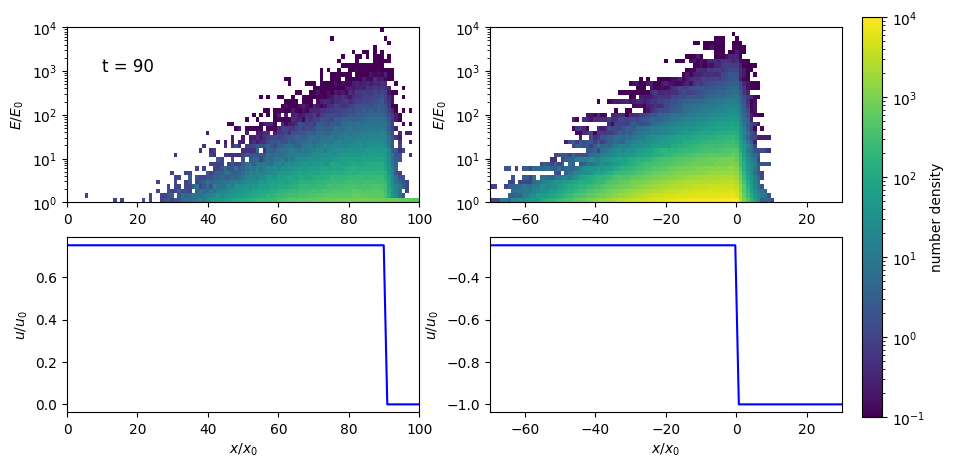

In [8]:
import matplotlib.animation as animation
import matplotlib.colors as mcolors

fig, (ax, ax2) = plt.subplots(2,2, figsize = (10, 5 ))
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$E/E_0$')

ax2[0].set_ylabel(r'$u/u_0$')
ax2[0].set_xlabel(r'$x/x_0$')
ax2[0].set_xlim([0, 100])

ax[1].set_yscale('log')
ax[1].set_ylabel(r'$E/E_0$')

ax2[1].set_ylabel(r'$u/u_0$')
ax2[1].set_xlabel(r'$x/x_0$')
ax2[1].set_xlim([-70, 30])

# bins in energy and space:
Ebins = 10**np.linspace(0, 4, 40)
Xbins = np.linspace(0, 100, 100) # moving bins
Xbins1 = np.linspace(-70, 30, 100) # stationary bins

# colorbar limits:
vmin = .1
vmax = 10**4

Tmax = 100
timesteps = np.linspace(1, Tmax, 20)
dt = Tmax/100

ims = [] # for animation

# plot advection field along E-X-hostogram:
vsh = 1 
v0 = 0. 
u0 = v0 - vsh 
u1 = 1./4 * u0 
v1 = u1 + vsh # = 3/4 vsh for q = 4
l_sh = 0.01 

adv = OneDimensionalTimeDependentShock( vsh, v1, v0, l_sh)
adv1 = OneDimensionalTimeDependentShock( 0, u1, u0, l_sh)

for i in range(len(timesteps)):
    dfT = df.loc[(df['T'] <= timesteps[i] + dt) & (df['T'] > timesteps[i])] 
    counts, xedges, yedges, im  =  ax[0].hist2d(dfT['X'], dfT['E'], bins = [Xbins, Ebins], weights = dfT['W'], norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), cmap = 'viridis')
    advField = np.zeros_like(Xbins)
    advField1 = np.zeros_like(Xbins1)
    for j in range(len(Xbins)):
        x = Xbins[j]
        advField[j] = adv.getField(Vector3d(x, 0., 0.), timesteps[i])[0]
    dfT = df1.loc[(df1['T'] <= timesteps[i] + dt )]
    counts, xedges, yedges, im5  =  ax[1].hist2d(dfT['X'], dfT['E'], bins = [Xbins1, Ebins], weights = dfT['W'], norm=mcolors.LogNorm(vmin=vmin, vmax=vmax), cmap = 'viridis')
    for j in range(len(Xbins)):
        x = Xbins1[j] 
        advField1[j] = adv1.getField(Vector3d(x, 0., 0.), timesteps[i])[0]

    im2,  = ax2[0].plot(Xbins, advField, label = 't = %i' %(timesteps[i]), color = 'blue')
    im4,  = ax2[1].plot(Xbins1, advField1, label = 't = %i' %(timesteps[i]), color = 'blue')
    im3  = ax[0].text(10,1000, 't = %i' %(timesteps[i]), fontsize=12)
    
    ims.append([im, im2, im3, im4, im5]) 
    

# Create a new axes for the colorbar
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])

# Add the colorbar to the new axes
fig.colorbar(im, cax=cbar_ax, label='number density')

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)

# SAVE ANIMATION WHEN MATPLOTLIB INLINE DOES NOT SHOW THE ANIMATION:
#ani.save("DSA.mp4")


Compare the spectra at the shock over time:

/var/folders/hm/8552yhb509l530c14llpb1ym0000gn/T/ipykernel_90359/2636325046.py:16: RuntimeWarning: invalid value encountered in divide
  dJ = J/np.sqrt(H[0])


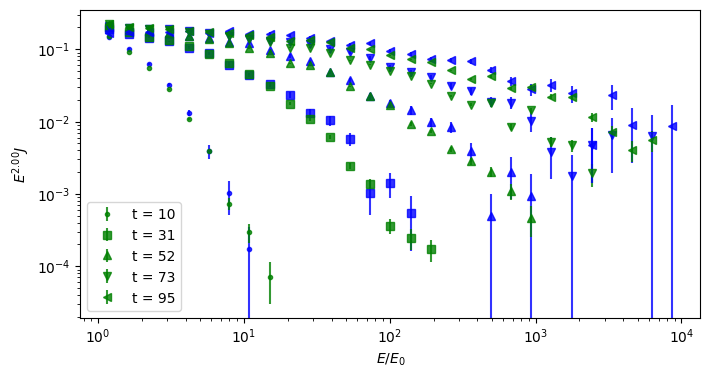

In [9]:
def energy_spectrum(df, bins, weighted = False):
    # calculates the energy spectrum J, dJ of dataframe df
    # returns touple (N, dN, bin_center)
    # weights are taken into account if weighted == True

    if weighted:
        HW = np.histogram(df['E'], bins = bins, weights = df["W"])
    H = np.histogram(df['E'], bins = bins)

    bin_edges = H[1]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    if weighted:
        J = HW[0]/bin_width
        dJ = J/np.sqrt(H[0]) 
    else:
        J = H[0]/bin_width
        dJ = np.sqrt(H[0])/bin_width  

    return J,  dJ, bin_center

fig, axs = plt.subplots(1, 1, figsize = (8, 4), sharex = True, sharey = True)

bins = 10**np.linspace(0, 4, 30)
timesteps = np.linspace(10, Tmax-5, 5)

e = 2 # spectrum weighted by E^2
# distance in Myr:
i = 0
dx = 5 # bin around shock

for t in timesteps:

    xsh = vsh * t # shock position moves
    J, dJ, bin_center = energy_spectrum(df.loc[ (df['X'] >=  xsh - dx) & (df['X'] < xsh) & (df['T'] <= t + dt)  & (df['T'] > t )], bins, weighted = True)
    axs.errorbar(bin_center, J*bin_center**e/Nlab, yerr = dJ*bin_center**e/Nlab, linestyle = '', marker = marker[i], color = 'blue', alpha = .8)
    # J, dJ normalized by number of candidates

    xsh = 0
    J, dJ, bin_center = energy_spectrum(df1.loc[ (df1['X'] >=  xsh - dx) & (df1['X'] < xsh) & (df1['T'] <= t + dt)], bins, weighted = True)
    axs.errorbar(bin_center, J*bin_center**e/(Nstat * Nobs) , yerr = dJ*bin_center**e/(Nstat * Nobs) , linestyle = '', marker = marker[i], color = 'green', alpha = .8, label = 't = %i' %t)
    # J, dJ normalized by number of candidates & integration steps
    i = i + 1

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_ylabel(r'$E^{%.2f} J$' %e)
axs.set_xlabel(r'$E/E_0$')
axs.set_xlabel(r'$E/E_0$')
axs.legend()
plt.show()

Spectrum and acceleration time of stationary simulation (green) and moving shock (blue) are the same. 